In [ ]:
import os
import requests
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model, model_selection

import time
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.models import resnet18
import numpy as np
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device:", DEVICE.upper())

# manual random seed is used for dataset partitioning
# to ensure reproducible results across runs
RNG = torch.Generator().manual_seed(42)

Running on device: CUDA


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory


Step 1 - Choose and load dataset

In [ ]:
# CIFAR 10 dataset
normalize = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ]
)

# Train data
train_set = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=normalize
)
# Train loader
train_loader = DataLoader(train_set, batch_size=256, shuffle=True, num_workers=2)

# Test data
# we split held out data into test and validation set
test_set = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=normalize
)
test_loader = DataLoader(test_set, batch_size=256, shuffle=True, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


Step 2 - split train set on forget / retain

In [ ]:
np.where(np.array(train_set.targets) == 1)[0].shape

(5000,)

In [ ]:
# Choose random forget indecies from cars
# Index of class
class_index = 1
class_set = np.where(np.array(train_set.targets) == 1)[0]
# Percantage of whole data ( from class )
amount = 0.1 # 10 %
amount_int = class_set.shape[0] * amount

# Get indeces
forget_idx = np.random.choice(class_set, int(amount_int))

# construct indices of retain from those of the forget set
forget_mask = np.zeros(len(train_set.targets), dtype=bool)
forget_mask[forget_idx] = True
retain_idx = np.arange(forget_mask.size)[~forget_mask]

# split train set into a forget and a retain set
forget_set = torch.utils.data.Subset(train_set, forget_idx)
retain_set = torch.utils.data.Subset(train_set, retain_idx)

forget_loader = torch.utils.data.DataLoader(
    forget_set, batch_size=256, shuffle=True, num_workers=2
)
retain_loader = torch.utils.data.DataLoader(
    retain_set, batch_size=256, shuffle=True, num_workers=2, generator=RNG
)


In [ ]:
len(train_set)

50000

Step 3 - Choose and load model

In [ ]:
dataloaders = {
    "train": train_loader,
    "val": test_loader
}

dataset_sizes = {"train": len(train_set), "val": len(test_set)}
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(DEVICE)
                    labels = labels.to(DEVICE)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [ ]:
model_ft = resnet18(weights=None, num_classes=10)
# num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 10
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
# model_ft.fc = nn.Linear(num_ftrs, 10)

model_ft = model_ft.to(DEVICE)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=15)

Epoch 0/14
----------
train Loss: 1.3960 Acc: 0.4942
val Loss: 1.2255 Acc: 0.5711

Epoch 1/14
----------
train Loss: 1.0041 Acc: 0.6422
val Loss: 1.0913 Acc: 0.6179

Epoch 2/14
----------
train Loss: 0.8018 Acc: 0.7156
val Loss: 0.8971 Acc: 0.6878

Epoch 3/14
----------
train Loss: 0.6661 Acc: 0.7641
val Loss: 1.0991 Acc: 0.6417

Epoch 4/14
----------
train Loss: 0.5568 Acc: 0.8041
val Loss: 0.8380 Acc: 0.7215

Epoch 5/14
----------
train Loss: 0.4600 Acc: 0.8373
val Loss: 0.8582 Acc: 0.7181

Epoch 6/14
----------
train Loss: 0.3762 Acc: 0.8673
val Loss: 0.8738 Acc: 0.7360

Epoch 7/14
----------
train Loss: 0.1577 Acc: 0.9514
val Loss: 0.7695 Acc: 0.7718

Epoch 8/14
----------
train Loss: 0.0833 Acc: 0.9774
val Loss: 0.8362 Acc: 0.7733

Epoch 9/14
----------
train Loss: 0.0494 Acc: 0.9888
val Loss: 0.9267 Acc: 0.7699

Epoch 10/14
----------
train Loss: 0.0286 Acc: 0.9947
val Loss: 1.0208 Acc: 0.7714

Epoch 11/14
----------
train Loss: 0.0157 Acc: 0.9976
val Loss: 1.1291 Acc: 0.7666

Ep

In [ ]:
torch.save(model_ft.state_dict(), "train_paramst.pt")

In [ ]:
dataloaders = {
    "train": retain_loader,
    "val": test_loader
}

dataset_sizes = {"train": len(retain_set), "val": len(test_set)}

In [ ]:
model_ft_retain = resnet18(weights=None, num_classes=10)
# num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 10
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
# model_ft.fc = nn.Linear(num_ftrs, 10)

model_ft_retain = model_ft_retain.to(DEVICE)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft_retain.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
%%time
model_ft_retain = train_model(model_ft_retain, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=15)

Epoch 0/14
----------
train Loss: 1.3827 Acc: 0.5019
val Loss: 1.2093 Acc: 0.5743

Epoch 1/14
----------
train Loss: 0.9899 Acc: 0.6513
val Loss: 1.1175 Acc: 0.6169

Epoch 2/14
----------
train Loss: 0.8058 Acc: 0.7158
val Loss: 0.9632 Acc: 0.6644

Epoch 3/14
----------
train Loss: 0.6624 Acc: 0.7659
val Loss: 0.8518 Acc: 0.7126

Epoch 4/14
----------
train Loss: 0.5512 Acc: 0.8058
val Loss: 0.9650 Acc: 0.6852

Epoch 5/14
----------
train Loss: 0.4500 Acc: 0.8415
val Loss: 0.9241 Acc: 0.7110

Epoch 6/14
----------
train Loss: 0.3648 Acc: 0.8722
val Loss: 0.9374 Acc: 0.7147

Epoch 7/14
----------
train Loss: 0.1509 Acc: 0.9538
val Loss: 0.7994 Acc: 0.7669

Epoch 8/14
----------
train Loss: 0.0776 Acc: 0.9794
val Loss: 0.8852 Acc: 0.7650

Epoch 9/14
----------
train Loss: 0.0444 Acc: 0.9910
val Loss: 0.9816 Acc: 0.7650

Epoch 10/14
----------
train Loss: 0.0230 Acc: 0.9961
val Loss: 1.1126 Acc: 0.7639

Epoch 11/14
----------
train Loss: 0.0129 Acc: 0.9979
val Loss: 1.2591 Acc: 0.7631

Ep

In [ ]:
torch.save(model_ft_retain.state_dict(), "retain_params.pt")

In [ ]:
def unlearning(net, retain, forget, validation):
    """Unlearning by fine-tuning.

    Fine-tuning is a very simple algorithm that trains using only
    the retain set.

    Args:
      net : nn.Module.
        pre-trained model to use as base of unlearning.
      retain : torch.utils.data.DataLoader.
        Dataset loader for access to the retain set. This is the subset
        of the training set that we don't want to forget.
      forget : torch.utils.data.DataLoader.
        Dataset loader for access to the forget set. This is the subset
        of the training set that we want to forget. This method doesn't
        make use of the forget set.
      validation : torch.utils.data.DataLoader.
        Dataset loader for access to the validation set. This method doesn't
        make use of the validation set.
    Returns:
      net : updated model
    """
    epochs = 5

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    net.train()

    for _ in range(epochs):
        for inputs, targets in retain:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
        scheduler.step()

    net.eval()
    return net

In [ ]:
def accuracy(net, loader):
    """Return accuracy on a dataset given by the data loader."""
    correct = 0
    total = 0
    for inputs, targets in loader:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        outputs = net(inputs)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    return correct / total


print(f"Train set accuracy: {100.0 * accuracy(model_ft, train_loader):0.1f}%")
print(f"Test set accuracy: {100.0 * accuracy(model_ft, test_loader):0.1f}%")

Train set accuracy: 93.4%
Test set accuracy: 73.6%


In [ ]:
print(f"Train set accuracy: {100.0 * accuracy(model_ft_retain, train_loader):0.1f}%")
print(f"Test set accuracy: {100.0 * accuracy(model_ft_retain, test_loader):0.1f}%")

Train set accuracy: 98.0%
Test set accuracy: 76.7%


In [ ]:
model_ft_forget = resnet18(weights=None, num_classes=10)
model_ft_forget.load_state_dict(torch.load("train_paramst.pt"))
model_ft_forget.to(DEVICE)

# Execute the unlearing routine. This might take a few minutes.
# If run on colab, be sure to be running it on  an instance with GPUs
%%time
model_ft_forget = unlearning(model_ft_forget, retain_loader, forget_loader, test_loader)

In [ ]:
print(f"Retain set accuracy: {100.0 * accuracy(model_ft_forget, retain_loader):0.1f}%")
print(f"Test set accuracy: {100.0 * accuracy(model_ft_forget, test_loader):0.1f}%")

Retain set accuracy: 99.6%
Test set accuracy: 76.8%


In [ ]:

def compute_losses(net, loader):
    """Auxiliary function to compute per-sample losses"""

    criterion = nn.CrossEntropyLoss(reduction="none")
    all_losses = []

    for inputs, targets in loader:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

        logits = net(inputs)
        losses = criterion(logits, targets).numpy(force=True)
        for l in losses:
            all_losses.append(l)

    return np.array(all_losses)


train_losses = compute_losses(model_ft, train_loader)
test_losses = compute_losses(model_ft, test_loader)

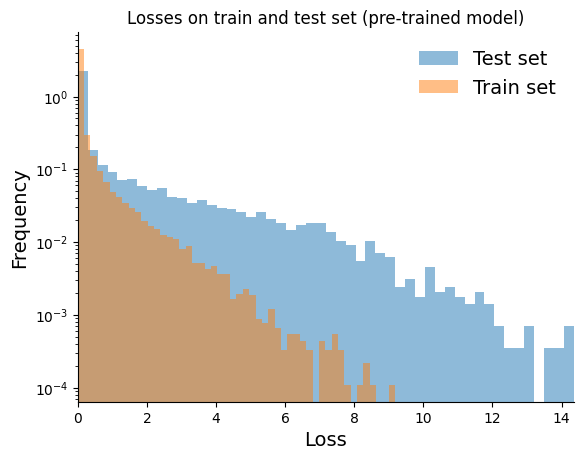

In [ ]:
# plot losses on train and test set
plt.title("Losses on train and test set (pre-trained model)")
plt.hist(test_losses, density=True, alpha=0.5, bins=50, label="Test set")
plt.hist(train_losses, density=True, alpha=0.5, bins=50, label="Train set")
plt.xlabel("Loss", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xlim((0, np.max(test_losses)))
plt.yscale("log")
plt.legend(frameon=False, fontsize=14)
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.show()


In [ ]:
def simple_mia(sample_loss, members, n_splits=10, random_state=0):
    """Computes cross-validation score of a membership inference attack.

    Args:
      sample_loss : array_like of shape (n,).
        objective function evaluated on n samples.
      members : array_like of shape (n,),
        whether a sample was used for training.
      n_splits: int
        number of splits to use in the cross-validation.
    Returns:
      scores : array_like of size (n_splits,)
    """

    unique_members = np.unique(members)
    if not np.all(unique_members == np.array([0, 1])):
        raise ValueError("members should only have 0 and 1s")

    attack_model = linear_model.LogisticRegression()
    cv = model_selection.StratifiedShuffleSplit(
        n_splits=n_splits, random_state=random_state
    )
    return model_selection.cross_val_score(
        attack_model, sample_loss, members, cv=cv, scoring="accuracy"
    )

In [ ]:
forget_losses = compute_losses(model_ft, forget_loader)
len(forget_losses)

500

In [ ]:
randomize = np.arange(len(test_losses))
np.random.shuffle(randomize)

In [ ]:

forget_losses = compute_losses(model_ft, forget_loader)

# Since we have more forget losses than test losses, sub-sample them, to have a class-balanced dataset.
# np.random.shuffle(test_losses)
test_losses = test_losses[randomize][: len(forget_losses)]

samples_mia = np.concatenate((test_losses, forget_losses)).reshape((-1, 1))
labels_mia = [0] * len(test_losses) + [1] * len(forget_losses)

mia_scores = simple_mia(samples_mia, labels_mia)

print(
    f"The MIA has an accuracy of {mia_scores.mean():.3f} on forgotten vs unseen images"
)

The MIA has an accuracy of 0.803 on forgotten vs unseen images


In [ ]:
ft_forget_losses = compute_losses(model_ft_retain, forget_loader)
ft_forget_losses_rt = ft_forget_losses
ft_test_losses = compute_losses(model_ft_retain, test_loader)
ft_test_losses = ft_test_losses[randomize][:len(ft_forget_losses)]
# make sure we have a balanced dataset for the MIA
# ft_test_losses = ft_test_losses[:200]
# assert len(ft_test_losses) == len(ft_forget_losses)
# np.random.shuffle()

ft_samples_mia = np.concatenate((ft_test_losses, ft_forget_losses)).reshape((-1, 1))
labels_mia = [0] * len(ft_test_losses) + [1] * len(ft_forget_losses)

In [ ]:

ft_mia_scores_rt = simple_mia(ft_samples_mia, labels_mia)

print(
    f"The MIA has an accuracy of {ft_mia_scores_rt.mean():.3f} on forgotten vs unseen images"
)

The MIA has an accuracy of 0.556 on forgotten vs unseen images


In [ ]:
ft_forget_losses = compute_losses(model_ft_forget, forget_loader)
ft_forget_losses_fr = ft_forget_losses
ft_test_losses = compute_losses(model_ft_forget, test_loader)
ft_test_losses = ft_test_losses[randomize][:len(ft_forget_losses)]
# make sure we have a balanced dataset for the MIA
# ft_test_losses = ft_test_losses[:200]
# assert len(ft_test_losses) == len(ft_forget_losses)
# np.random.shuffle()

ft_samples_mia = np.concatenate((ft_test_losses, ft_forget_losses)).reshape((-1, 1))
labels_mia = [0] * len(ft_test_losses) + [1] * len(ft_forget_losses)

In [ ]:

ft_mia_scores = simple_mia(ft_samples_mia, labels_mia)

print(
    f"The MIA has an accuracy of {ft_mia_scores.mean():.3f} on forgotten vs unseen images"
)

The MIA has an accuracy of 0.539 on forgotten vs unseen images


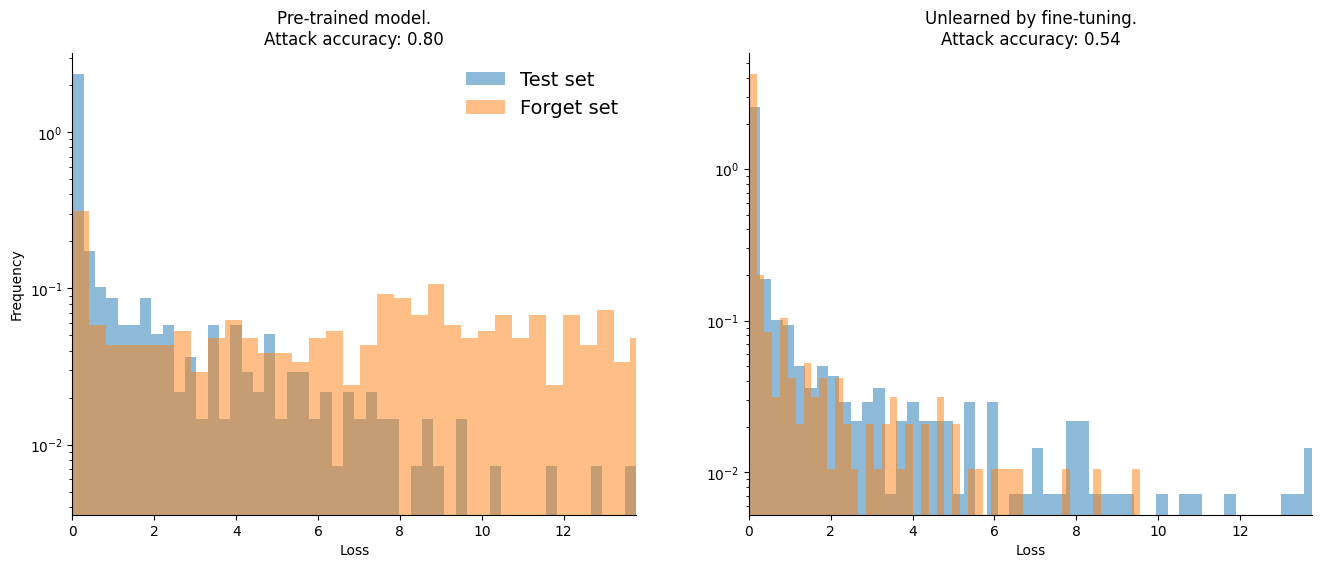

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.set_title(f"Pre-trained model.\nAttack accuracy: {mia_scores.mean():0.2f}")
ax1.hist(test_losses, density=True, alpha=0.5, bins=50, label="Test set")
ax1.hist(forget_losses, density=True, alpha=0.5, bins=50, label="Forget set")

ax2.set_title(
    f"Unlearned by fine-tuning.\nAttack accuracy: {ft_mia_scores.mean():0.2f}"
)
ax2.hist(ft_test_losses, density=True, alpha=0.5, bins=50, label="Test set")
ax2.hist(ft_forget_losses, density=True, alpha=0.5, bins=50, label="Forget set")

ax1.set_xlabel("Loss")
ax2.set_xlabel("Loss")
ax1.set_ylabel("Frequency")
ax1.set_yscale("log")
ax2.set_yscale("log")
ax1.set_xlim((0, np.max(test_losses)))
ax2.set_xlim((0, np.max(test_losses)))
for ax in (ax1, ax2):
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
ax1.legend(frameon=False, fontsize=14)
plt.show()

In [ ]:
AD = np.linalg.norm(ft_forget_losses_fr-ft_forget_losses_rt)

In [ ]:
AD

39.568783

In [ ]:
# Visualizations
# CIFAR 10 dataset
normalize = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)

# Train data
train_set_tensor = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transforms.ToTensor()
)

forget_set_tensor = torch.utils.data.Subset(train_set_tensor, forget_idx)

forget_loader_tensor = torch.utils.data.DataLoader(
    forget_set, batch_size=1, shuffle=True, num_workers=2
)

Files already downloaded and verified


In [ ]:
!pip install grad-cam